In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import os

from tensorflow import keras
from tensorflow.python.keras import layers
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

from pathlib import Path
# from glob import glob

from utils import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
by_merge_map = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A', 11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K', 21:'L', 22:'M', 23:'N', 24:'O', 25:'P', 26:'Q', 27:'R', 28:'S', 29:'T', 30:'U', 31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z', 36:'a', 37:'b', 38:'d', 39:'e', 40:'f', 41:'g', 42:'h', 43:'n', 44:'q', 45:'r', 46:'t'}
by_merge_map_new = {}
poplist = []

for k in by_merge_map.keys():
    if k >= 10 and k <= 35:
        by_merge_map_new[k-10] = by_merge_map[k]
        
root_path, data_path = get_root_path('mnist_portfolio')

paths = data_path.glob('*.csv')

In [4]:
lower = 10
upper = 35

for p in paths:
    if 'Rensade' in str(p):
        x_train, y_train = gen_sets(p)
x_train[x_train < 150] = 0
y_train = y_train - 10

In [5]:
pic_no = 1
def fix_image(image, plot=False):
    pic = trim_img(image)
    
    return square_pick(pic, plot)


In [6]:
no = 0
last = len(x_train)
for i, x in enumerate(x_train):
    if i%100 == 0:print(f'{i}/{last}')

    x_train[i]= fix_image(x_train[i], 2).reshape(28,28)
    
    


0/65017
100/65017
200/65017
300/65017
400/65017
500/65017
600/65017
700/65017
800/65017
900/65017
1000/65017
1100/65017
1200/65017
1300/65017
1400/65017
1500/65017
1600/65017
1700/65017
1800/65017
1900/65017
2000/65017
2100/65017
2200/65017
2300/65017
2400/65017
2500/65017
2600/65017
2700/65017
2800/65017
2900/65017
3000/65017
3100/65017
3200/65017
3300/65017
3400/65017
3500/65017
3600/65017
3700/65017
3800/65017
3900/65017
4000/65017
4100/65017
4200/65017
4300/65017
4400/65017
4500/65017
4600/65017
4700/65017
4800/65017
4900/65017
5000/65017
5100/65017
5200/65017
5300/65017
5400/65017
5500/65017
5600/65017
5700/65017
5800/65017
5900/65017
6000/65017
6100/65017
6200/65017
6300/65017
6400/65017
6500/65017
6600/65017
6700/65017
6800/65017
6900/65017
7000/65017
7100/65017
7200/65017
7300/65017
7400/65017
7500/65017
7600/65017
7700/65017
7800/65017
7900/65017
8000/65017
8100/65017
8200/65017
8300/65017
8400/65017
8500/65017
8600/65017
8700/65017
8800/65017
8900/65017
9000/65017
9100/65017


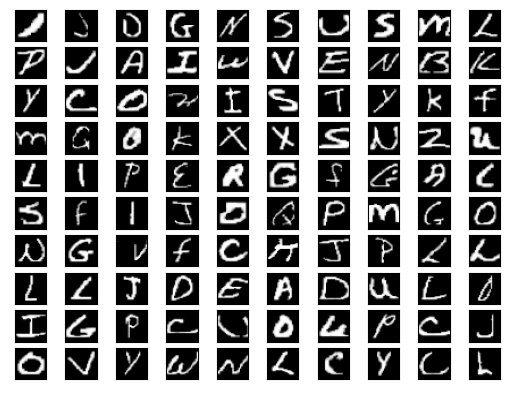

In [7]:
for i, r in enumerate(np.random.randint(0, len(x_train), 100)):
    
    plt.subplot(10,10,i+1)
    plt.imshow(x_train[r], cmap='gray')
    plt.xticks([]), plt.yticks([])

The mean picture of the training set

### Modeling


Restore to oneliner

In [8]:
x_train = np.asarray(x_train.reshape(65017, 28, 28))

In [9]:
num_classes = len(np.unique(y_train))
input_shape = (28, 28, 1)

# x_train = x_train
x_train = x_train.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)

y_train = keras.utils.to_categorical(y_train.ravel(), num_classes)

In [10]:
from sklearn.model_selection import train_test_split

x_train1, x_test, y_train1, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=215)

In [11]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from keras import Model

class Model_Class():
    def __init__(self,
                 model_path=''):

        self.model = self.load_model(model_path)
        # self.model = self.__get_model()
        self.conv_layers, self.layer_names = self.__get_convlayers()
        self.preds = ""

    def load_model(self, path):
        self.model = keras.models.load_model(path)
        return self.model

    def grad_cam(self, image, layer=None):
        self.preds = self.predict(image)

        if type(layer) is list:
            heatmap_list, superimposed_list = {},{}
            for layer_num in layer:
                heatmap = self.make_gradcam_heatmap(np.expand_dims(image, axis=0), layer_num, np.argmax(self.preds[0]))
                superimposed_img = self.superimpose(image,heatmap)
                heatmap_list[self.model.layers[layer_num]._name] = heatmap
                superimposed_list[self.model.layers[layer_num]._name] = superimposed_img
            return image, heatmap_list, superimposed_list
        else:
            heatmap = self.make_gradcam_heatmap(np.expand_dims(image, axis=0), layer, np.argmax(self.preds[0]))
            superimposed_img = self.superimpose(image,heatmap)

            heatmap = cv2.resize(heatmap, dsize=(28,28))
            return image, heatmap, superimposed_img


    def make_gradcam_heatmap(self, img_array, layer=None, pred_index=None):
        # First, we create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions
        if layer == None: layer=self.conv_layers[-1]
        model = self.model
        grad_model = Model(
            [model.inputs], [model.layers[layer].output, model.output]
            # [model.inputs], [model.get_layer(self.layer_names[-1]).output, model.output]
        )

        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    def predict(self, pic):
        x = cv2.resize(pic, dsize=(28,28))
        # x = model_preprocess(pic)
        if len(x.shape) < 4:
          x = np.expand_dims(x, axis=0)

        preds = self.model.predict(x)
        return preds

    def superimpose(self, pic,heatmap):
        # img_numpy = np.asarray(np.clip(pic, 0, 190))
        pic[pic > 0.4] = 1.0
        img_numpy = np.asarray(pic)
        # plt.imshow(pic)
    
        heatmap_resized = cv2.resize(heatmap, (img_numpy.shape[1], img_numpy.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        superimposed_img = 0.3*heatmap_resized[:,:,::-1] + img_numpy
        
        superimposed_img = superimposed_img.astype(np.uint8)
        return superimposed_img

    def __get_convlayers(self):
        list_conv_layers = []
        list_layer_names = []
        for i,l in enumerate(self.model.layers):
            # print(str(l).split('.'))
            if str(l).split('.')[2] == 'convolutional':
                list_conv_layers.append(i)
                list_layer_names.append(l._name)
        return list_conv_layers, list_layer_names

model = Model_Class('./model/2emnist_save.h5')
model.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)        

In [12]:
score = model.model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.011308044195175171
Test accuracy: 0.9963088035583496


In [13]:
def plot_gradcam(image, heatmap, superimposed_img):
  if type(heatmap) == dict and type(superimposed_img) == dict:
      nlen = len(heatmap)
      fig, ax = plt.subplots(nlen,3, figsize=(10, nlen*3.5))
      # fig.figsize=(20,20)
      for i, (k, img) in enumerate(heatmap.items()):
          ax[i,0].imshow(img+50)
          ax[i,1].set_title(k)
          ax[i,1].imshow(superimposed_img[k])
          ax[i,2].imshow(image)
  else:
    plt.subplot(1,3, 1)
    plt.imshow(heatmap)
    plt.subplot(1,3, 2)
    plt.imshow(superimposed_img)
    plt.subplot(1,3, 3)
    plt.imshow(image)

In [14]:
model.conv_layers

[0, 1, 4, 5, 8]

1/1 [==============================] - 0s 103ms/step


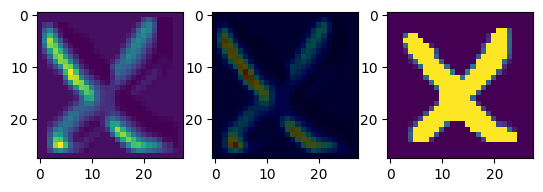

In [15]:
image, heatmap, superimposed_image = model.grad_cam(x_test[2],0)
plot_gradcam(image, heatmap, superimposed_image)

1/1 [==============================] - 0s 16ms/step


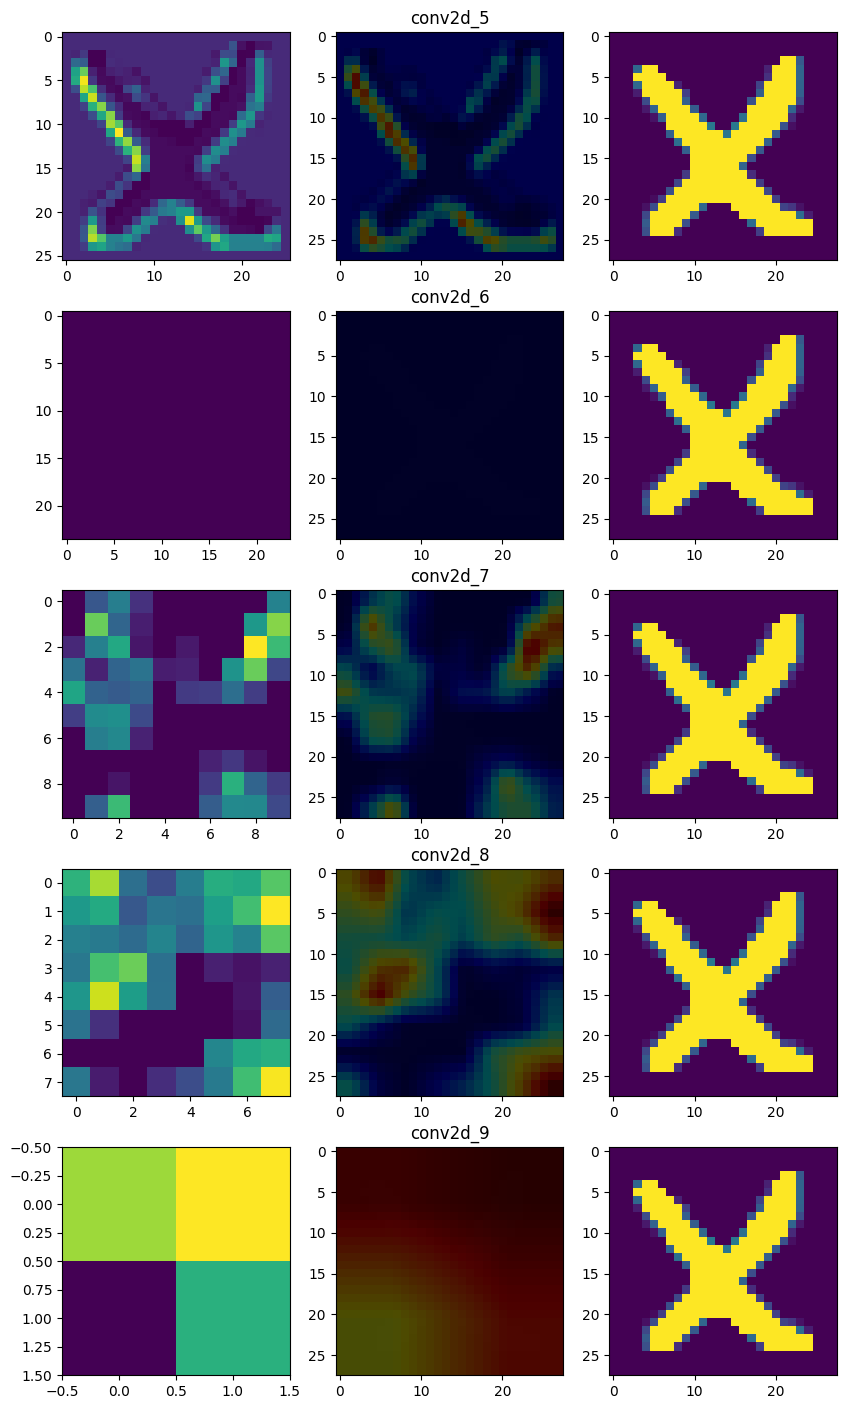

In [16]:
image, heatmap, superimposed_img = model.grad_cam(x_test[2], model.conv_layers)
plot_gradcam(image, heatmap, superimposed_img)